In [2]:
# Make sure we've got the latest fastbook version
! pip install -Uqq fastbook dotenv
import fastbook
fastbook.setup_book()

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.


In [3]:
# Connect to MongoDB and retrieve image URLs and metadata
from pymongo import MongoClient
import pandas as pd
from dotenv import load_dotenv
import os

# Load the dotenv file
load_dotenv()

# Grab the MONGO_URI from local or from Kaggle
mongo_uri = os.getenv('MONGO_URI')
if not mongo_uri:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    mongo_uri = user_secrets.get_secret("MONGO_URI")

# Connect to the MongoDB client
client = MongoClient(mongo_uri)
 
# Access the database and collection
db = client['test']  # Replace with your database name
collection = db['cameratrapmedias']  # Replace with your collection name
 
# Query the collection to retrieve the first 150 records with image URLs, metadata, and the first index of 'relativePath'
data = list(collection.aggregate([
    {
        '$project': {
            '_id': 0,
            'publicURL': 1,
            'timestamp': 1,
            'relativePathSecond': { '$arrayElemAt': ['$relativePath', 1] }
        }
    },
    { '$limit': 150 }
]))
 
# Convert the data to a pandas DataFrame for exploration
df = pd.DataFrame(data)

# Export the small array to a CSV file for preview
df.to_csv('small_array.csv', index=False)
 
# Display the first few rows of the DataFrame
print(df.head())

            timestamp  \
0 2024-01-27 13:33:15   
1 2024-01-24 18:56:50   
2 2024-01-24 19:01:54   
3 2024-01-24 19:03:05   
4 2024-01-24 19:04:19   

                                                                                                                   publicURL  \
0                   https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-01-30_prologis_02/DCIM/100MEDIA/SYFW0060.JPG   
1  https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-01-30_Learnin_platform_camera_test/DCIM/100MEDIA/SYFW0001.JPG   
2  https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-01-30_Learnin_platform_camera_test/DCIM/100MEDIA/SYFW0002.JPG   
3  https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-01-30_Learnin_platform_camera_test/DCIM/100MEDIA/SYFW0004.JPG   
4  https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-01-30_Learnin_platform_camera_test/DCIM/100MEDIA/SYFW0006.JPG   

                        relativePathSecond  
0                   2024-01-30_prol

Now that we have a connection to the MongoDB server and access to the URLs, let's use the `fastbook` library to simplify image handling and prepare for model inference.

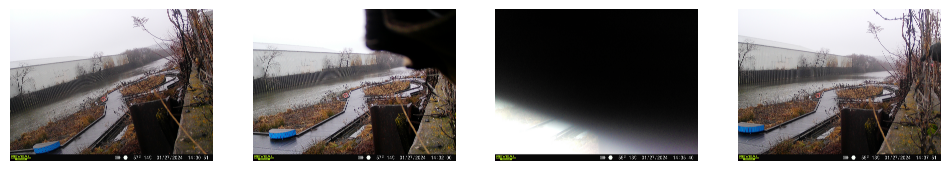

In [4]:
# Preview 4 images from the publicURL column using fastbook
from fastbook import *
from fastai.vision.widgets import *

# Create a directory to save the images
path = Path('images')
path.mkdir(exist_ok=True)

# Download and display the first 4 images
urls = df['publicURL'][75:79]
for i, url in enumerate(urls):
    # Download the image
    dest = path/f'image_{i}.jpg'
    download_url(url, dest)

# Display the images using fastai utilities
images = [PILImage.create(path/f'image_{i}.jpg') for i in range(4)]
show_images(images, nrows=1, ncols=4, figsize=(12, 4))

We clearly have the ability to access the URLs and index through images - now there are two paths to take
1. Try using the full image Google speciesnet model (v4.0.1b) as is - pre processing these images by vertical cropping top and bottom into right size (480x480px)